# Car valuation

Описание данных

- `id`: идентификатор записи;
- `url`: URL записи о продаже;
- `region`: регион;
- `region_url`: URL региона;
- `price`: стоимость;
- `year`: год выпуска;
- `manufacturer`: производитель;
- `model`: модель;
- `fuel`: тип топлива;
- `odometer`: количество пройденных миль;
- `title_status`: статус;
- `transmission`: коробка передач;
- `image_url`: URL изображения;
- `description`: указанное описание;
- `state`: штат;
- `lat`: широта;
- `long`: долгота;
- `posting_date`: дата размещения объявления о продаже;
- `price_category`: категория цены;
- `year`: год.

In [359]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

## Загрузка данных

In [360]:
#снимем ограничение на количество отображаемых столбцов

pd.options.display.max_columns = None

In [361]:
df = pd.read_csv('28.6 df_out.csv')
print(df.shape)
df.head()

(10000, 20)


,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


## *Data preparation*

### Обработка типов данных

In [362]:
# Пропуски есть у 11 признаков, много признаков содержит тип object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

In [363]:
# Заменим тип object на наиболее подходящие
df = df.convert_dtypes()

In [364]:
# метод convert_dtypes() не работает для типа временных данных, поэтому заменим отдельно
df.date = pd.to_datetime(df.date)
df.posting_date = pd.to_datetime(df.posting_date, utc = True)

In [365]:
# после приведения к одному типу, определим различаются ли столбцы date и posting_date
df[df.posting_date == df.date].shape



(9998, 20)

In [366]:
# это один признак, удалим лишний столбец
df = df.drop(['date'], axis = 1)

In [367]:
# проверим получившиеся типы данных
df.dtypes

id                              Int64
url                            string
region                         string
region_url                     string
price                           Int64
year                            Int64
manufacturer                   string
model                          string
fuel                           string
odometer                        Int64
title_status                   string
transmission                   string
image_url                      string
description                    string
state                          string
lat                           Float64
long                          Float64
posting_date      datetime64[ns, UTC]
price_category                 string
dtype: object

### Обработка пропусков в данных

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              10000 non-null  Int64              
 1   url             10000 non-null  string             
 2   region          10000 non-null  string             
 3   region_url      10000 non-null  string             
 4   price           10000 non-null  Int64              
 5   year            9964 non-null   Int64              
 6   manufacturer    10000 non-null  string             
 7   model           9872 non-null   string             
 8   fuel            9937 non-null   string             
 9   odometer        10000 non-null  Int64              
 10  title_status    9834 non-null   string             
 11  transmission    9955 non-null   string             
 12  image_url       9998 non-null   string             
 13  description     9998 non-null   

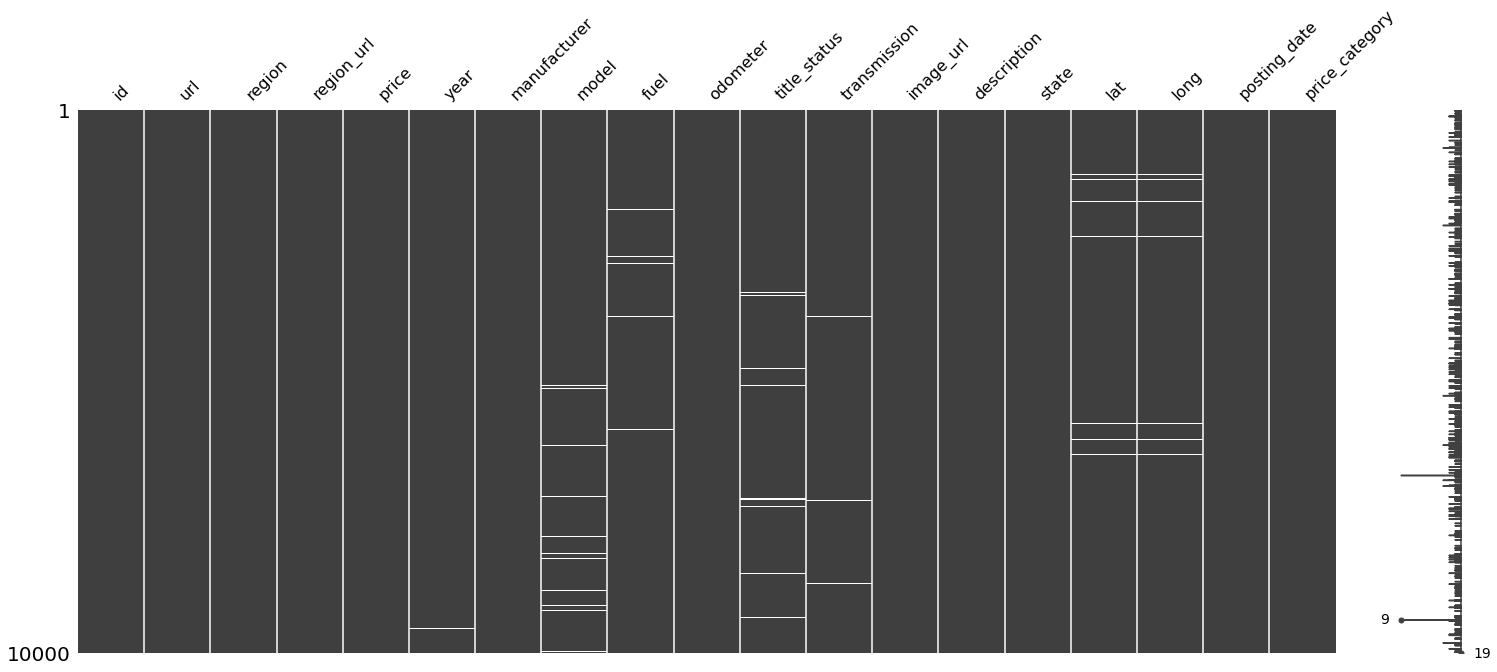

In [369]:
msno.matrix(df);

В данных не много пропусков, менее 20% на признак, поэтому численные пропуски заменим на медиану, а качественные - на моду или новое значение 'other'

In [370]:
# числовые значения заменим на медиану
num_values = ('year', 'lat', 'long')
for column in num_values:
    df[column] = df[column].fillna(df[column].median())
    

In [371]:
df.title_status.value_counts()

clean         9518
rebuilt        171
salvage         92
lien            35
missing         16
parts only       2
Name: title_status, dtype: Int64

In [372]:
# Заменим качественные переменные на other
qual_var = ('model', 'fuel', 'title_status', 'transmission', 'image_url', 'description')
for column in qual_var:
    df[column] = df[column].fillna('other')

In [373]:
# заменим временные данные на моду
df['posting_date'] = df['posting_date'].fillna(df.posting_date.mode())

In [374]:
# Проверим теперь пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id              10000 non-null  Int64              
 1   url             10000 non-null  string             
 2   region          10000 non-null  string             
 3   region_url      10000 non-null  string             
 4   price           10000 non-null  Int64              
 5   year            10000 non-null  Int64              
 6   manufacturer    10000 non-null  string             
 7   model           10000 non-null  string             
 8   fuel            10000 non-null  string             
 9   odometer        10000 non-null  Int64              
 10  title_status    10000 non-null  string             
 11  transmission    10000 non-null  string             
 12  image_url       10000 non-null  string             
 13  description     10000 non-null  

### Проверка данных на аномалии и дубликаты

In [375]:
# проверим данные на наличие дубликатов
df[df.duplicated()].shape

(0, 19)

In [376]:
# проверим данные на выборосы
# Посмотрим, какие есть численные данные
df.select_dtypes(include = np.number).head()

,id,price,year,odometer,lat,long
0,7308295377,54990,2020,27442,35.06,-85.25
1,7316380095,16942,2016,60023,40.821805,-74.061962
2,7313733749,35590,2017,14048,33.779214,-84.411811
3,7308210929,14500,2013,117291,35.715954,-78.655304
4,7316474668,21800,2021,8000,40.6548,-73.6097


In [377]:
# Оценим, в каких атрибутах есть выбросы
# Очевидно, значимые выбросы в: price, year, odometer
df.describe()

,id,price,year,odometer,lat,long
count,1.000000e+04,1.000000e+04,10000.00000,10000.00000,10000.000000,10000.000000
mean,7.311541e+09,2.067842e+04,2010.93540,93324.13400,38.601045,-94.105452
std,4.477653e+06,1.246230e+05,9.65541,63181.17499,5.816596,18.049670
min,7.208550e+09,5.000000e+02,1915.00000,0.00000,-67.144243,-158.069300
25%,7.308189e+09,7.900000e+03,2008.00000,39147.25000,34.920000,-108.558634
50%,7.312757e+09,1.574950e+04,2013.00000,89000.00000,39.298522,-88.000050
75%,7.315274e+09,2.799000e+04,2017.00000,136875.00000,42.381700,-80.998136
max,7.317090e+09,1.234568e+07,2022.00000,283466.00000,64.947500,173.885502


In [378]:
# 25  и 75 квантили атрибута price
q_75_price = df.describe().loc['75%', 'price']
q_25_price = df.describe().loc['25%', 'price']

In [379]:
# заменим выбросы атрибута price на граничные значения
df.price = df.price.apply(lambda x: q_75_price if x > q_75_price
                            else (q_25_price if x < q_25_price else x))

In [380]:
# проделаем то же для признаков year и odometer
q_75_year = df.describe().loc['75%', 'year']
q_25_year = df.describe().loc['25%', 'year']

In [381]:
df.year = df.year.apply(lambda x: q_75_year if x > q_75_year
                            else (q_25_year if x < q_25_year else x))

In [382]:
q_75_odometer = df.describe().loc['75%', 'odometer']
q_25_odometer = df.describe().loc['25%', 'odometer']

In [383]:
df.odometer = df.odometer.apply(lambda x: q_75_odometer if x > q_75_odometer
                            else (q_25_odometer if x < q_25_odometer else x))

In [384]:
# Проверим выбросы теперь
df.describe()

,id,price,year,odometer,lat,long
count,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.311541e+09,17149.19390,2012.723500,87718.503800,38.601045,-94.105452
std,4.477653e+06,8256.73475,3.638017,39834.361107,5.816596,18.049670
min,7.208550e+09,7900.00000,2008.000000,39147.250000,-67.144243,-158.069300
25%,7.308189e+09,7900.00000,2008.000000,39148.562500,34.920000,-108.558634
50%,7.312757e+09,15749.50000,2013.000000,89000.000000,39.298522,-88.000050
75%,7.315274e+09,27990.00000,2017.000000,136875.000000,42.381700,-80.998136
max,7.317090e+09,27990.00000,2017.000000,136875.000000,64.947500,173.885502


## Feature engineering

### Преобразование категориальных переменных

In [385]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category'],
      dtype='object')

In [386]:
# Признаки url, image_url и region_url не информативны для построения модели, удалим их
df = df.drop(columns=['url', 'region_url', 'image_url'], axis = 1)

In [387]:
# Преобразуем переменную description, укажем только длину этого признака
df['len_description'] = df.description.apply(lambda x: len(x))

In [388]:
# название моделей слишком длинные, развернутые, посмотрим количество уникальных
df.model.nunique()

3467

In [389]:
# попробуем сократить, выбрав только первое слово
df['short_model'] = df.model.apply(lambda x: x.split()[0])

In [390]:
# тогда количество уникальных 
df.short_model.nunique()

989

In [391]:
# Имеются следующие категориальные переменные

data_cat = ('region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 'state', 'price_category')

In [392]:
ohe = OneHotEncoder(sparse = False)
for x in data_cat:
    ohe.fit(df[[x]])
    ohe_data = ohe.transform(df[[x]])
    df[ohe.get_feature_names()] = ohe_data

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [393]:
df.head()

,id,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,description,state,lat,long,posting_date,price_category,len_description,short_model,x0_SF bay area,x0_abilene,x0_akron / canton,x0_albany,x0_albuquerque,x0_altoona-johnstown,x0_amarillo,x0_ames,x0_anchorage / mat-su,x0_ann arbor,x0_annapolis,x0_appleton-oshkosh-FDL,x0_asheville,x0_ashtabula,x0_athens,x0_atlanta,x0_auburn,x0_augusta,x0_austin,x0_bakersfield,x0_baltimore,x0_baton rouge,x0_battle creek,x0_beaumont / port arthur,x0_bellingham,x0_bemidji,x0_bend,x0_billings,x0_binghamton,x0_birmingham,x0_bismarck,x0_bloomington,x0_bloomington-normal,x0_boise,x0_boone,x0_boston,x0_boulder,x0_bowling green,x0_bozeman,x0_brainerd,x0_brownsville,x0_brunswick,x0_buffalo,x0_butte,x0_cape cod / islands,x0_catskills,x0_cedar rapids,x0_central NJ,x0_central louisiana,x0_central michigan,x0_champaign urbana,x0_charleston,x0_charlotte,x0_charlottesville,x0_chattanooga,x0_chautauqua,x0_chicago,x0_chico,x0_chillicothe,x0_cincinnati,x0_clarksville,x0_cleveland,x0_clovis / portales,x0_college station,x0_colorado springs,x0_columbia,x0_columbia / jeff city,x0_columbus,x0_corpus christi,x0_corvallis/albany,x0_cumberland valley,x0_dallas / fort worth,x0_danville,x0_dayton / springfield,x0_daytona beach,x0_decatur,x0_del rio / eagle pass,x0_delaware,x0_denver,x0_des moines,x0_detroit metro,x0_dothan,x0_dubuque,x0_duluth / superior,x0_east idaho,x0_east oregon,x0_eastern CO,x0_eastern CT,x0_eastern NC,x0_eastern kentucky,x0_eastern montana,x0_eastern panhandle,x0_eastern shore,x0_eau claire,x0_el paso,x0_elko,x0_elmira-corning,x0_erie,x0_eugene,x0_evansville,x0_fairbanks,x0_fargo / moorhead,x0_farmington,x0_fayetteville,x0_finger lakes,x0_flagstaff / sedona,x0_flint,x0_florence,x0_florence / muscle shoals,x0_florida keys,x0_fort collins / north CO,x0_fort dodge,x0_fort smith,x0_fort wayne,x0_frederick,x0_fredericksburg,x0_fresno / madera,x0_ft myers / SW florida,x0_gadsden-anniston,x0_gainesville,x0_galveston,x0_glens falls,x0_gold country,x0_grand forks,x0_grand island,x0_grand rapids,x0_great falls,x0_green bay,x0_greensboro,x0_greenville / upstate,x0_gulfport / biloxi,x0_hanford-corcoran,x0_harrisburg,x0_harrisonburg,x0_hartford,x0_hattiesburg,x0_hawaii,x0_heartland florida,x0_helena,x0_hickory / lenoir,x0_high rockies,x0_hilton head,x0_holland,x0_houma,x0_houston,x0_hudson valley,x0_humboldt county,x0_huntington-ashland,x0_huntsville / decatur,x0_imperial county,x0_indianapolis,x0_inland empire,x0_iowa city,x0_ithaca,x0_jackson,x0_jacksonville,x0_janesville,x0_jersey shore,x0_jonesboro,x0_joplin,x0_kalamazoo,x0_kalispell,"x0_kansas city, MO",x0_kenai peninsula,x0_kennewick-pasco-richland,x0_kenosha-racine,x0_killeen / temple / ft hood,x0_kirksville,x0_klamath falls,x0_knoxville,x0_kokomo,x0_la crosse,x0_la salle co,x0_lafayette,x0_lafayette / west lafayette,x0_lake charles,x0_lake of the ozarks,x0_lakeland,x0_lancaster,x0_lansing,x0_laredo,x0_las cruces,x0_las vegas,x0_lawrence,x0_lawton,x0_lehigh valley,x0_lewiston / clarkston,x0_lexington,x0_lima / findlay,x0_lincoln,x0_little rock,x0_logan,x0_long island,x0_los angeles,x0_louisville,x0_lubbock,x0_lynchburg,x0_macon / warner robins,x0_madison,x0_maine,x0_manhattan,x0_mankato,x0_mansfield,x0_mason city,x0_mattoon-charleston,x0_mcallen / edinburg,x0_meadville,x0_medford-ashland,x0_memphis,x0_mendocino county,x0_merced,x0_milwaukee,x0_minneapolis / st paul,x0_missoula,x0_mobile,x0_modesto,x0_mohave county,x0_monroe,x0_monterey bay,x0_montgomery,x0_morgantown,x0_moses lake,x0_muncie / anderson,x0_muskegon,x0_myrtle beach,x0_nashville,x0_new hampshire,x0_new haven,x0_new orleans,x0_new river valley,x0_new york city,x0_norfolk / hampton roads,x0_north central FL,x0_north dakota,x0_north jersey,x0_north mississippi,x0_north platte,x0_northeast SD,x0_northern WI,x0_northern michigan,x0_northern panhandle,x0_northwest CT,x0_northwest GA,x0_northwest KS,x0_northwest OK,x0_ocala,x0_odessa / midland,x0_ogden-clearfield,x0_okaloo

In [394]:
df.shape

(10000, 1498)

In [395]:
# удалим лишние столбцы
df = df.drop(columns=['region', 'manufacturer', 'short_model', 'fuel', 'title_status', 'transmission', 
                        'state', 'price_category', 'description', 'model'], axis = 1)

### Преобразование числовых переменных, Min-Max нормализация

In [404]:
df.posting_date.dt.year

0       2021.0
1       2021.0
2       2021.0
3       2021.0
4       2021.0
         ...  
9995    2021.0
9996    2021.0
9997    2021.0
9998    2021.0
9999    2021.0
Name: posting_date, Length: 10000, dtype: float64

In [409]:
# Создадим новую фичу - количество лет, прошедших с изготовления до продажи
df['post_year'] = df.posting_date.dt.year
df['diff_year'] = df.apply(lambda x: x.post_year - x.year, axis = 1)

In [410]:
# определим числовые переменные

variables = ['price', 'year', 'odometer', 'lat', 'long', 'len_description', 'diff_year']
data_nv = df[variables]

In [411]:
scaler = MinMaxScaler()
scaler.fit(data_nv)
scaled = scaler.transform(data_nv)


In [412]:
data_nv[variables] = scaled
for var in variables:
    data_nv = data_nv.rename(columns={var: var + '_mm'})

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [413]:
df[data_nv.columns] = data_nv

In [414]:
# удалим лишние столбцы
df = df.drop(columns=variables, axis = 1)
df = df.drop(['post_year'], axis = 1)

In [416]:
# также удалим атрибут posting_date
df = df.drop(['posting_date'], axis = 1)

In [418]:
df.shape

(10000, 1488)

## *Modelling*